#  AI Graphics | NYU 2024
### Instructor: Luiz Velho

## Assignment - Deform a source mesh to form a target mesh using 3D loss functions

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("2.2.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

from plotly.subplots import make_subplots
torch.manual_seed(777)

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

## 1. Load an obj file and create a Meshes object

Download the target 3D model of a dolphin. It will be saved locally as a file called `dolphin.obj`.

In [3]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2024-04-21 21:58:56--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.34.122, 13.226.34.53, 13.226.34.83, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.34.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj.10’

dolphin.obj.10      100%[===================>] 153.09K  --.-KB/s    in 0.01s   

2024-04-21 21:58:56 (10.1 MB/s) - ‘dolphin.obj.10’ saved [156763/156763]



In [4]:
# Load the dolphin mesh.
trg_obj = os.path.join('dolphin.obj')

In [5]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

/home/m/miniconda3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [6]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(4, device)

1.1 The source mesh is a sphere of radius 1 centered at (0, 0, 0). To speed up the optimization process, we should scale normalize the target mesh and center it at the origin, making it fit the unit sphere. Do this operations with the `verts`tensor and create a `Meshes` object called "trg_mesh" with the normalized vertices and the faces indices.

1.2 Visualize the source and target meshes using `Plotly` integration.

In [14]:
##############################################################################
# Code for 1.1
centered_verts = verts-verts.mean()
largest_distance=centered_verts.norm(dim=1).max()
normalized_verts = centered_verts/largest_distance

trg_mesh=Meshes([normalized_verts], [faces_idx])


# Code for 1.2
import plotly.graph_objects as go
import numpy as np


def plotly_submeshes(verts,faces,size):
    specs=[[{"type": "mesh3d"} for i in range(size[1])] for j in range(size[0])]
    fig = make_subplots(size[0],size[1],specs=specs)
    for j in range(size[0]):
        for i in range(size[1]):
            fig.add_trace(go.Mesh3d(x=verts[j][i][:,0],y=verts[j][i][:,1],z=verts[j][i][:,2],i=faces[j][i][:,0],j=faces[j][i][:,1],k=faces[j][i][:,2]),row=j+1,col=i+1)
    return fig


verts1=trg_mesh.verts_packed().cpu()
faces1=trg_mesh.faces_packed().cpu()
#fig1 = go.Figure(data=[go.Mesh3d(x=verts1[:,0], y=verts1[:,1], z=verts1[:,2],i=faces1[:, 0],j=faces1[:, 1],k=faces1[:, 2])])
#fig1.show()
verts5=verts.cpu()

verts2=src_mesh.verts_packed().cpu()
faces2=src_mesh.faces_packed().cpu()
#fig2 =go.Figure(data=[go.Mesh3d(x=verts2[:,0], y=verts2[:,1], z=verts2[:,2],i=faces2[:, 0],j=faces2[:, 1],k=faces2[:, 2])])
#fig2.show()


fig1 = plotly_submeshes([[verts1,verts2]],[[faces1,faces2]],[1,2])
fig1.show()
fig3 = go.Figure(data=[go.Mesh3d(x=verts1[:,0], y=verts1[:,1], z=verts1[:,2],i=faces1[:, 0],j=faces1[:, 1],k=faces1[:, 2]),go.Mesh3d(x=verts2[:,0], y=verts2[:,1], z=verts2[:,2],i=faces2[:, 0],j=faces2[:, 1],k=faces2[:, 2],opacity=0.5)])
fig3.show()
##############################################################################

###  Visualizing point clouds with Matplotlib

We can also sample points from the surfaces and visualize them using Matplotlib. It can be a useful to have a coarse estimation of the surface during iterations in the optimization process.

In [8]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

1.3 Use the function `plot_pointcloud` to see the initial pointcloud

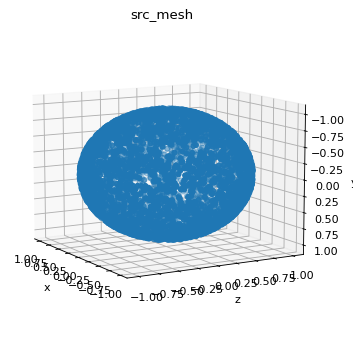

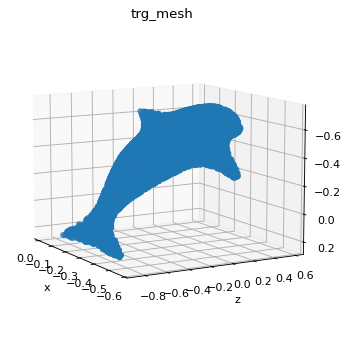

In [9]:
%matplotlib inline
##############################################################################
# Code for 1.3
plot_pointcloud(src_mesh,"src_mesh")
plot_pointcloud(trg_mesh,"trg_mesh")
##############################################################################

## 2. Optimization loop

Starting from a sphere mesh, we learn the offset to each vertex in the mesh such that the predicted mesh is closer to the target mesh at each optimization step. To achieve this we minimize the distance between the predicted (deformed) and target mesh, defined as the **chamfer distance** between the set of pointclouds resulting from **differentiably sampling points** from their surfaces.

However, solely minimizing the chamfer distance between the predicted and the target mesh will lead to a non-smooth shape. We enforce smoothness by adding **shape regularizers** to the objective. Namely, we add:

+ `mesh_edge_length`, which minimizes the length of the edges in the predicted mesh.
+ `mesh_normal_consistency`, which enforces consistency across the normals of neighboring faces.
+ `mesh_laplacian_smoothing`, which is the laplacian regularizer.
We will learn to deform the source mesh by offsetting its vertices

In [ ]:
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [ ]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

OBS: Note that you need the "trg_mesh" from 1.1 for the optimization code to work.

In [ ]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []
total_losses=[]
%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    total_losses.append(float(loss.detach().cpu()))

    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    # Optimization step
    loss.backward()
    optimizer.step()


## Visualize the loss

In [ ]:
def plot_losses(loss_dict, size=(13,5)):
  fig = plt.figure(figsize=size)
  ax = fig.gca()
  for loss_name, loss_values in loss_dict.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

In [ ]:
losses = {"chamfer loss": chamfer_losses,
          "edge loss": edge_losses,
          "normal loss": normal_losses,
          "laplacian loss": laplacian_losses,
          "total loss":total_losses}
plot_losses(losses, (18, 10))

## Save the predicted mesh

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

2.1 Scale normalize back the `final_verts` to the original target size



In [ ]:
##############################################################################
# Code for 2.1
# a modification in previous block to remember the size
final_verts_nback=final_verts*largest_distance
##############################################################################

In [ ]:
# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts_nback, final_faces)

2.2 Visualize the target mesh and the final mesh using `Plotly`. Qualitatively, what do you think of the result?

2.3 Take a look at the **Loss vs Iteration** graph, paying attention to how the losses are decreasing. Do you think it would be possible to achieve a reasonable result with less iterations? Is it worth to run with more iterations? Explain you thoughts, then run the optimization loop again making the changes to validate your hypothesis.

2.4 The loss function used for this task is a linear combination of four losses. Let `w_chamfer = 1.0` and set the other coefficients to zero. Run the  optimization loop again with this configuration and describe the result.

**[EXTRA] E.1 Experiment other coefficients configurations and describe the results.**

2.5 Experiment with others optimizers such as `Adam` and `RMSprop` in place of `SGD`. Also, try changing the learning rate (`lr`), and `momentum` when these parameters are applied. What do you observe in terms of speed of convergence and quality of final results?




In [ ]:
##############################################################################
# Code for 2.2

verts4=final_verts_nback.detach().cpu()
faces4=final_faces.cpu()
#fig4 =go.Figure(data=[go.Mesh3d(x=verts4[:,0], y=verts4[:,1], z=verts4[:,2],i=faces4[:, 0],j=faces4[:, 1],k=faces4[:, 2])])
#fig4=make_subplots(1,2,specs=[[{"type": "mesh3d"}, {"type": "mesh3d"}]])
#fig4.add_trace(go.Mesh3d(x=verts4[:,0], y=verts4[:,1], z=verts4[:,2],i=faces4[:, 0],j=faces4[:, 1],k=faces4[:, 2]), row=1, col=1)

#fig4.add_trace(go.Mesh3d(x=verts5[:,0], y=verts5[:,1], z=verts5[:,2],i=faces1[:, 0],j=faces1[:, 1],k=faces1[:, 2]), row=1, col=2)
fig4=plotly_submeshes([[verts4,verts5]],[[faces4,faces1]],[1,2])

##############################################################################

## Discusstion for 2.2

The left figure is the final mesh, and the right one is the target mesh. 

The tail of the final mesh is not as symmetric as that of the target mesh. ~~Additionally, the left part of the tail from the target mesh has obvious artifacts; these can be easily identified even without comparison.~~ Meanwhile, the belly of the final mesh has prominent lines on each side, in contrast to the smooth belly of the target mesh. Also, the dorsal fin on the final mesh is not sharp and appears to have lost a corner compared to the target mesh.

In conclusion, the optimized (final) mesh resembles a dolphin, though some details are lost.

In [ ]:
##############################################################################
# Code for 2.3 part1
def plot_losses_log(loss_dict, size=(13,5)):
  fig = plt.figure(figsize=size)
  ax = fig.gca()
  for loss_name, loss_values in loss_dict.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16")
  ax.set_yscale('log') 
losses_less = {"chamfer loss": chamfer_losses[250:],
          "edge loss": edge_losses[250:],
          "normal loss": normal_losses[250:],
          "laplacian loss": laplacian_losses[250:]}
plot_losses_log(losses, (18, 10))
##################################################################################

In [ ]:
# code for 2.3 part2
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
# Number of optimization steps
Niter = 4000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 2000
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []
total_losses=[]
%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    total_losses.append(float(loss.detach().cpu()))

    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    if i == 2000:
      for param_group in optimizer.param_groups:
        param_group['lr'] /= 2

    # Optimization step
    loss.backward()
    optimizer.step()

final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
final_verts_nback=final_verts*largest_distance
final_obj = os.path.join('./', 'final_model3.obj')
save_obj(final_obj, final_verts_nback, final_faces)
##############################################################################

In [ ]:
# code for 2.3 part3 (visualize the loss)
losses = {"chamfer loss": chamfer_losses,
          "edge loss": edge_losses,
          "normal loss": normal_losses,
          "laplacian loss": laplacian_losses,
          "total loss":total_losses}
plot_losses_log(losses, (18, 10))

In [ ]:
# code for 2.3 part 4 (visualize the mesh)
verts6=final_verts_nback.detach().cpu()
faces6=final_faces.cpu()
#fig5=make_subplots(1,3,specs=[[{"type": "mesh3d"}, {"type": "mesh3d"}],[{"type": "mesh3d"}]])
#fig5.add_trace(go.Mesh3d(x=verts4[:,0], y=verts4[:,1], z=verts4[:,2],i=faces4[:, 0],j=faces4[:, 1],k=faces4[:, 2]), row=1, col=1)
#fig5.add_trace(go.Mesh3d(x=verts6[:,0], y=verts6[:,1], z=verts6[:,2],i=faces6[:, 0],j=faces6[:, 1],k=faces6[:, 2]), row=1, col=2)
#fig5.add_trace(go.Mesh3d(x=verts5[:,0], y=verts5[:,1], z=verts5[:,2],i=faces1[:, 0],j=faces1[:, 1],k=faces1[:, 2]), row=1, col=3)
fig5=plotly_submeshes([[verts4,verts6,verts5]],[[faces4,faces6,faces1]],[1,3])
fig5.show()

## Discussion for 2.3

To further observe the detaied loss variation, we plot the previous loss figure with the y coordinate scaling in logarithm. At the beginning of optimization process, the total loss and chamfer loss has a very high value and decline rapidly. After 1000 iterations, the total loss converges at 10^-2 scale, however, with oscillation.

I think even though the final mesh has a very close shape to the target mesh, the loss could even converge more than that. To be specific, after 2000 iterations, the final mesh shape is reasonable if only observed by human eye. On the other side, the optimized mesh can achieve a more authetic and detailed shape. 

Thus, I decided to run the optimization with more iterations and a decaying learning rate. The first figure in mesh visualization is 2000 iterations and the second is 4000 iterations. By human eyes, these figures don't make a difference. To measure it, the loss achieve a lower value (0.002073), which demonstrate our hypothesis that the loss could converge more.

In [ ]:
##############################################################################
# code for 2.4 part1 (optimization)
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 0.0
# Weight for mesh normal consistency
w_normal =  0.0
# Weight for mesh laplacian smoothing
w_laplacian =  0.0
# Plot period for the losses
plot_period = 1000
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []
total_losses=[]
%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    total_losses.append(float(loss.detach().cpu()))

    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)

    if i == 2000:
      for param_group in optimizer.param_groups:
        param_group['lr'] /= 2

    # Optimization step
    loss.backward()
    optimizer.step()

final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
final_verts_nback=final_verts*largest_distance
final_obj = os.path.join('./', 'final_model3.obj')
save_obj(final_obj, final_verts_nback, final_faces)
verts7=final_verts_nback.detach().cpu()
faces7=final_faces.cpu()

##############################################################################

In [ ]:
##############################################################################
# code for 2.4 part 2 (visualization)
plotly_submeshes([[verts7,verts5]],[[faces7,faces1]],(1,2))

## Discussion for 2.4

The loss converges much rapidly than the loss from optimization is bounded by 4 kinds of losses.

However, the final mesh with only chamfer loss is totally a failed mesh fit. The final mesh features a crude and uneven shape of a dolphin. The tip of fins and tip of mouth in the mesh becomes diffuse pinprick shape. It's hard to identify the species of the mesh.

In [10]:
##############################################################################
# code for E.1
def weight_experiment(src_mesh,trg_mesh,chamfer,edge,normal,laplacian,iterations):
    # The shape of the deform parameters is equal to the total number of vertices in src_mesh
    deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
    # The optimizer
    optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
    # Number of optimization steps
    Niter = iterations
    # Weight for the chamfer loss
    w_chamfer = chamfer
    # Weight for mesh edge loss
    w_edge = edge
    # Weight for mesh normal consistency
    w_normal = normal
    # Weight for mesh laplacian smoothing
    w_laplacian = laplacian
    # Plot period for the losses
    plot_period = 1000
    loop = tqdm(range(Niter))

    chamfer_losses = []
    laplacian_losses = []
    edge_losses = []
    normal_losses = []
    total_losses = []
    %matplotlib inline

    for i in loop:
        # Initialize optimizer
        optimizer.zero_grad()

        # Deform the mesh
        new_src_mesh = src_mesh.offset_verts(deform_verts)

        # We sample 5k points from the surface of each mesh
        sample_trg = sample_points_from_meshes(trg_mesh, 5000)
        sample_src = sample_points_from_meshes(new_src_mesh, 5000)

        # We compare the two sets of pointclouds by computing (a) the chamfer loss
        loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

        # and (b) the edge length of the predicted mesh
        loss_edge = mesh_edge_loss(new_src_mesh)

        # mesh normal consistency
        loss_normal = mesh_normal_consistency(new_src_mesh)

        # mesh laplacian smoothing
        loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

        # Weighted sum of the losses
        loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

        # Print the losses
        loop.set_description('total_loss = %.6f' % loss)

        # Save the losses for plotting
        chamfer_losses.append(float(loss_chamfer.detach().cpu()))
        edge_losses.append(float(loss_edge.detach().cpu()))
        normal_losses.append(float(loss_normal.detach().cpu()))
        laplacian_losses.append(float(loss_laplacian.detach().cpu()))
        total_losses.append(float(loss.detach().cpu()))

        # Plot mesh
        if i % plot_period == 0:
            plot_pointcloud(new_src_mesh, title="iter: %d" % i)

        if i == 2000:
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 2

        # Optimization step
        loss.backward()
        optimizer.step()

    final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)
    return final_verts, final_faces
##############################################################################

In [ ]:
# code for E.1 part 1 (edge length weight)
final_verts,final_faces = weight_experiment(src_mesh,trg_mesh,1.0,0.5,0.01,0.1,2000)

final_verts_nback = final_verts * largest_distance
#final_obj = os.path.join('./', 'final_model3.obj')
#save_obj(final_obj, final_verts_nback, final_faces)
verts8 = final_verts_nback.detach().cpu()
faces8 = final_faces.cpu()

final_verts,final_faces =weight_experiment(src_mesh,trg_mesh,1.0,2.0,0.01,0.1,2000)
final_verts_nback = final_verts * largest_distance
#final_obj = os.path.join('./', 'final_model3.obj')
#save_obj(final_obj, final_verts_nback, final_faces)
verts9 = final_verts_nback.detach().cpu()
faces9 = final_faces.cpu()

In [ ]:
##############################################################################
# code for E.1 part 1 (visualization)
plotly_submeshes([[verts8,verts9,verts5]],[[faces8,faces9,faces1]],(1,3))

## Discussion for E.1 part 1 (experiment on edge length weight)

The first figure represents the mesh optimized by edge length weight 0.5, the second by 2.0, and the third is the target mesh. 

We observed that the first mesh is not smooth enough to identify as a dolphin, suffering from stretching artifacts in mouse part and the tip of tail part. This indicates that the low edge length loss allows longer egdes exists, and further forms those streching artifacts.

For the second mesh, it almost achieves to be a good shape of a dolphin. Nevertheless, the left part of the dolphin has a little artifacts, failing to maintain the overall smooth of the optimizied mesh. We can infer that the spike shape artifacts is caused by the high edge length loss which enforcing shorter edges.

In [ ]:
# code for E.1 part 2 (normal consistency weight)
final_verts,final_faces = weight_experiment(src_mesh,trg_mesh,1.0,1.0,0.02,0.1,2000)
 
final_verts_nback = final_verts * largest_distance
#final_obj = os.path.join('./', 'final_model3.obj')
#save_obj(final_obj, final_verts_nback, final_faces)
verts10 = final_verts_nback.detach().cpu()
faces10 = final_faces.cpu()

final_verts,final_faces =weight_experiment(src_mesh,trg_mesh,1.0,1.0,0.005,0.1,2000)
final_verts_nback = final_verts * largest_distance
#final_obj = os.path.join('./', 'final_model3.obj')
#save_obj(final_obj, final_verts_nback, final_faces)
verts11 = final_verts_nback.detach().cpu()
faces11 = final_faces.cpu()

In [ ]:
##############################################################################
# code for E.1 part 2 (visualization)
plotly_submeshes([[verts10,verts11,verts5]],[[faces10,faces11,faces1]],(1,3))

## Discussion for E.1 part 2 (experiment on normal consistency weight)

We know that normal consistency is a local smooth constraint, and we expect that larger weight of normal consistency makes the mesh more smooth while lower has opposite effect. However the results of experienment are not as expected. Both optimized meshes characterize obvious artifacts on the tail part. We think that the first optimized mesh with larger weight of normal consistency needs more iteration to make sure conversion. Thus we decided to optimize with the same configuration again except through 4000 iterations. The optimization is shown below.

  0%|          | 0/4000 [00:00<?, ?it/s]

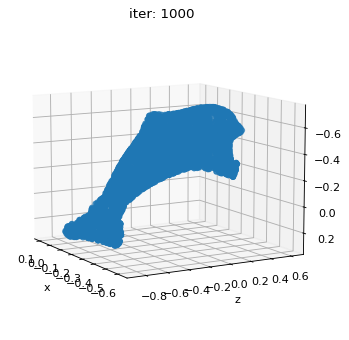

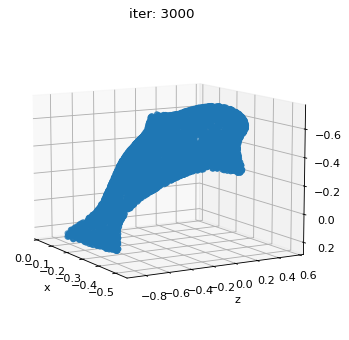

  0%|          | 0/4000 [00:00<?, ?it/s]

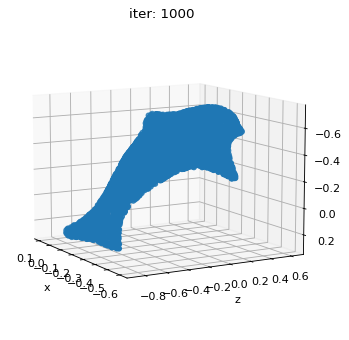

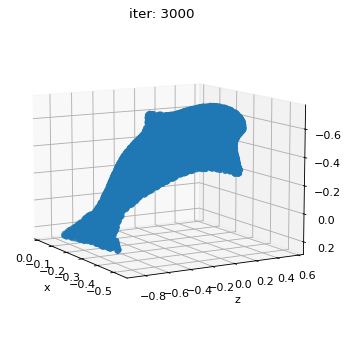

In [11]:
# code for E.1 part 2 (normal consistency weight, 4000 iterations)
final_verts,final_faces = weight_experiment(src_mesh,trg_mesh,1.0,1.0,0.02,0.1,4000)
 
final_verts_nback = final_verts * largest_distance
#final_obj = os.path.join('./', 'final_model3.obj')
#save_obj(final_obj, final_verts_nback, final_faces)
verts12 = final_verts_nback.detach().cpu()
faces12 = final_faces.cpu()

final_verts,final_faces =weight_experiment(src_mesh,trg_mesh,1.0,1.0,0.005,0.1,4000)
final_verts_nback = final_verts * largest_distance
#final_obj = os.path.join('./', 'final_model3.obj')
#save_obj(final_obj, final_verts_nback, final_faces)
verts13 = final_verts_nback.detach().cpu()
faces13 = final_faces.cpu()

In [15]:
##############################################################################
# code for E.1 part 2 (visualization)
plotly_submeshes([[verts12,verts13,verts5]],[[faces12,faces13,faces1]],(1,3))

## Discussion for E.1 part 2 continued (experiment on normal consistency weight)

The final meshes are now perfect shape of dolphin. The only difference we find is that the dorsal fin from the first mesh is more smooth.

In [ ]:
# code for E.1 part 3 (normal consistency weight)
final_verts,final_faces = weight_experiment(src_mesh,trg_mesh,1.0,1.0,0.02,0.1,2000)
 
final_verts_nback = final_verts * largest_distance
#final_obj = os.path.join('./', 'final_model3.obj')
#save_obj(final_obj, final_verts_nback, final_faces)
verts10 = final_verts_nback.detach().cpu()
faces10 = final_faces.cpu()

final_verts,final_faces =weight_experiment(src_mesh,trg_mesh,1.0,1.0,0.005,0.1,2000)
final_verts_nback = final_verts * largest_distance
#final_obj = os.path.join('./', 'final_model3.obj')
#save_obj(final_obj, final_verts_nback, final_faces)
verts11 = final_verts_nback.detach().cpu()
faces11 = final_faces.cpu()

# 3. Experimenting with Other Shapes

In [ ]:
# download the mug model - Mug by Microsoft is licensed under Creative Commons Attribution
# originally found at https://sketchfab.com/3d-models/mug-17c4808537f1448590378b3643c6da72
!wget https://raw.githubusercontent.com/hallpaz/3dsystems21/main/data/mug.obj
!wget https://github.com/alecjacobson/common-3d-test-models/blob/master/data/stanford-bunny.obj

3.1 Is it possible to deform any mesh into another? Explain your thoughts.

3.2 Run the experiment again and try to deform a sphere into a mug.

3.3 Change the `src_mesh` to a `torus`. You can import the torus primitive from `pytorch3d.utils`. Now, try to deform the torus into a mug.


**[Extra] E.2 Run the experiments again using other shapes (either find and download shapes from the internet or create your own models).**

In [ ]:
##############################################################################
# Code for 3.1 - 3.3
##############################################################################

# 4. Food for Thoughts

Let's say you have a big set Ω of arbitrary meshes, and 1 mesh or a small set Δ of meshes, for example from the same class, that you are instered in. How would you solve the problem of fitting meshes from Ω to meshes in Δ?